C:\Users\GeoffreyHadfield\AppData\Local\Temp\ipykernel_9688\2158597381.py:163: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, skiprows=8, header=None)


DataFrame Head:
   EMG 1 (mV) ACC X (G) ACC Y (G) ACC Z (G) GYRO X (deg/s) GYRO Y (deg/s)  \
0   -0.011582 -0.512146  0.898682 -0.408752      -0.229008       9.175572   
1   -0.007217 -0.542053  0.894287 -0.403015      -0.832061       8.679389   
2   -0.004196 -0.559082  0.886963 -0.397949      -0.610687       5.778626   
3   -0.002853 -0.593262  0.870056 -0.382935       0.389313        2.10687   
4   -0.004532 -0.617798   0.85437 -0.382935       1.236641      -2.045802   

  GYRO Z (deg/s)  
0      11.374045  
1      13.160305  
2      14.625955  
3      15.473283  
4      15.900764  

Descriptive Statistics:
         EMG 1 (mV)
count  1.502612e+06
mean  -9.531603e-03
std    4.268202e-02
min   -1.866316e+00
25%   -2.131690e-02
50%   -9.567400e-03
75%    1.678500e-03
max    2.753903e+00

Data types of each column:
EMG 1 (mV)        float64
ACC X (G)          object
ACC Y (G)          object
ACC Z (G)          object
GYRO X (deg/s)     object
GYRO Y (deg/s)     object
GYRO Z (deg/s)    

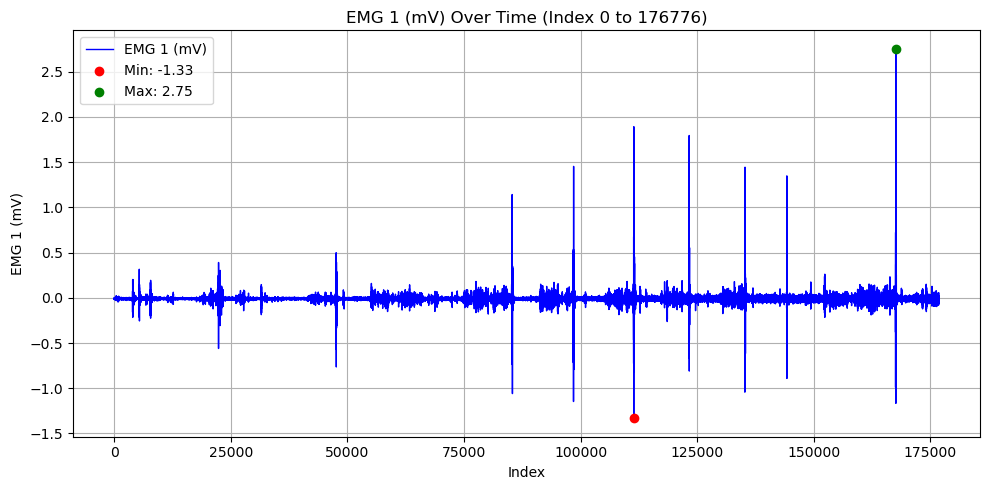


Metric: ACC X (G)
Count of ACC X (G)_min_flag: 2205
Count of ACC X (G)_max_flag: 161


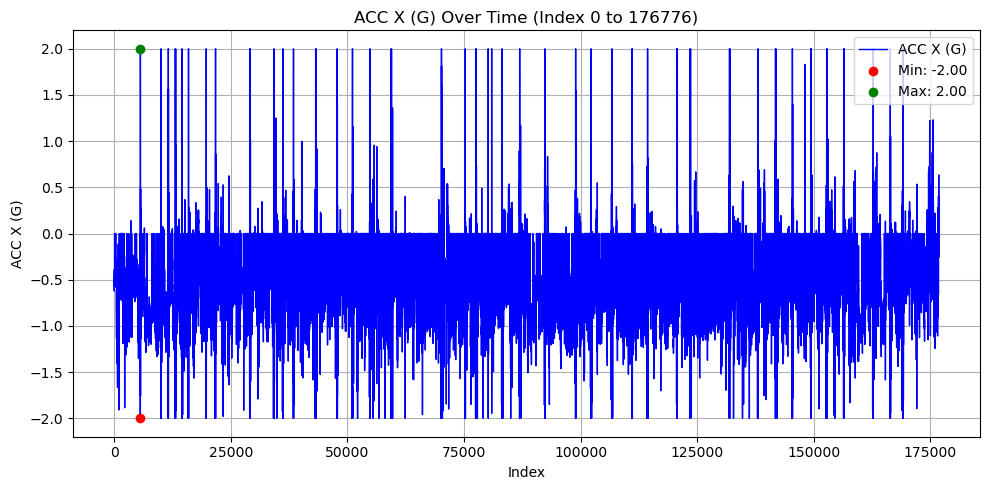


Metric: ACC Y (G)
Count of ACC Y (G)_min_flag: 542
Count of ACC Y (G)_max_flag: 4000


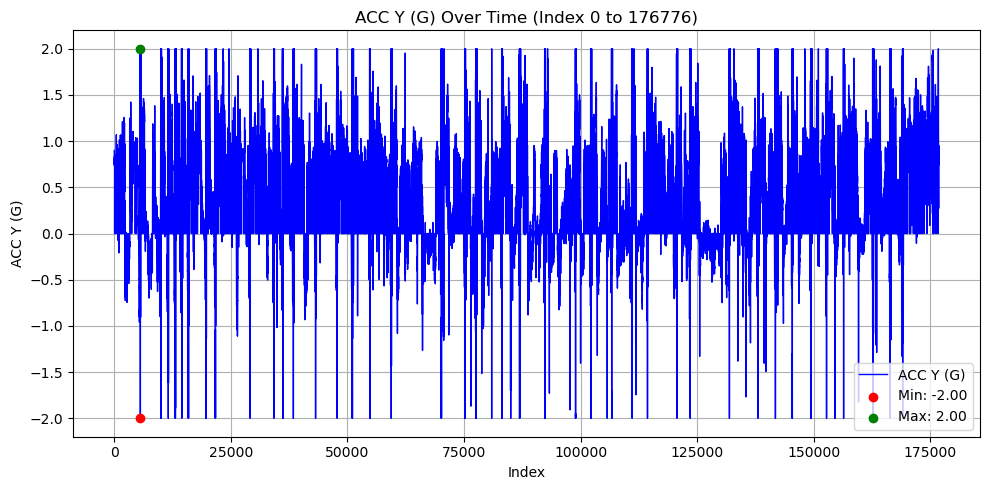


Metric: ACC Z (G)
Count of ACC Z (G)_min_flag: 1577
Count of ACC Z (G)_max_flag: 1139


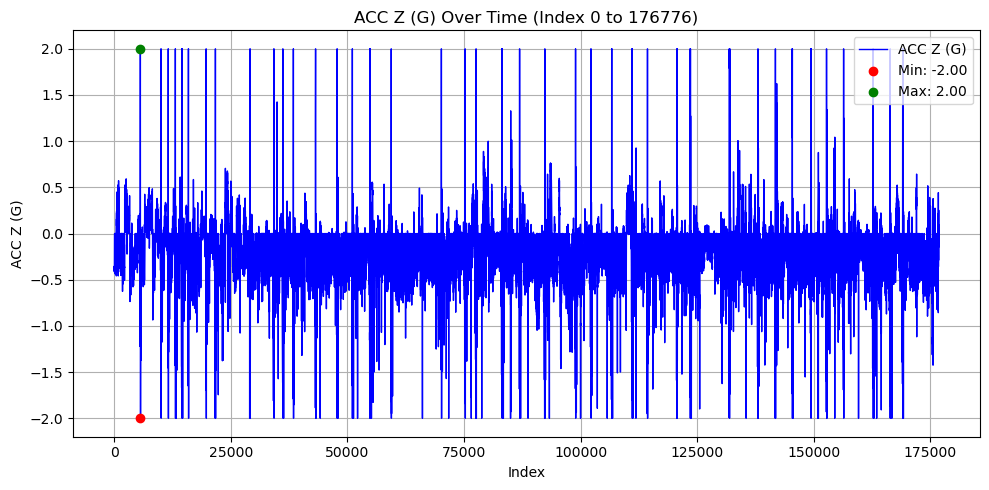


Metric: GYRO X (deg/s)
Count of GYRO X (deg/s)_min_flag: 1654
Count of GYRO X (deg/s)_max_flag: 4139


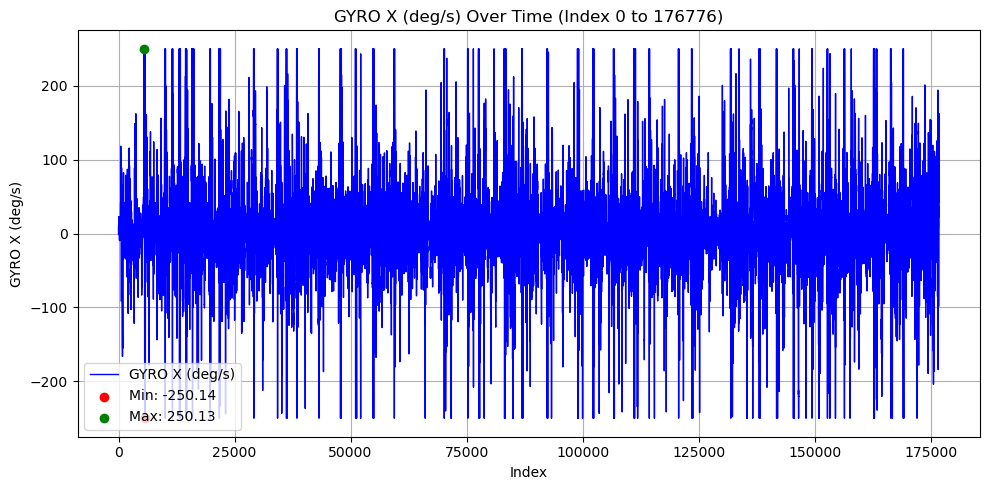


Metric: GYRO Y (deg/s)
Count of GYRO Y (deg/s)_min_flag: 2966
Count of GYRO Y (deg/s)_max_flag: 1325


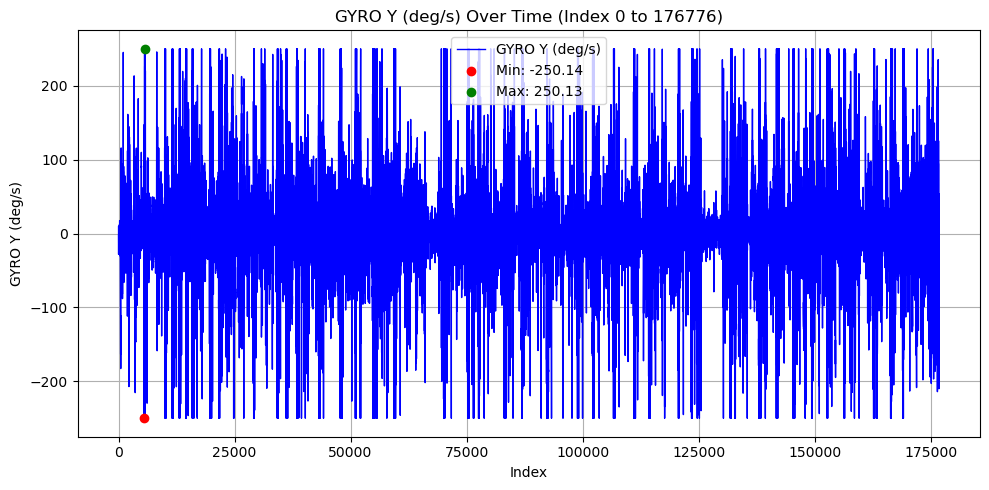


Metric: GYRO Z (deg/s)
Count of GYRO Z (deg/s)_min_flag: 2569
Count of GYRO Z (deg/s)_max_flag: 5075


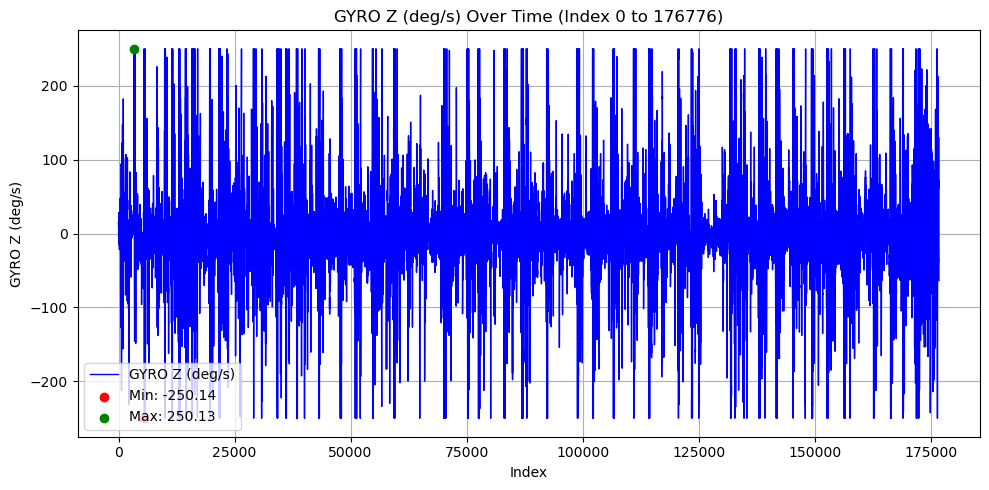


Sample of ACC/GYRO spike analysis (first 10 rows):
   avg_EMG 1 (mV)  min_EMG 1 (mV)  max_EMG 1 (mV)  is_global_min_EMG 1 (mV)  \
0       -0.007369       -0.019638        0.004868                     False   
1       -0.007476       -0.019638        0.004868                     False   
2       -0.007547       -0.019638        0.004868                     False   
3       -0.007650       -0.019638        0.004868                     False   
4       -0.007672       -0.019638        0.004868                     False   
5       -0.007670       -0.019638        0.004868                     False   
6       -0.007774       -0.019638        0.004868                     False   
7       -0.007938       -0.019638        0.004868                     False   
8       -0.008162       -0.021149        0.004868                     False   
9       -0.008381       -0.021317        0.004868                     False   

   is_global_max_EMG 1 (mV)  avg_ACC X (G)  min_ACC X (G)  max_ACC X (G)  \
0 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

########################################
# A) Function to build global min/max dictionary
########################################
def build_global_min_max(df, columns_to_analyze):
    """
    Returns a dictionary mapping each column to its global min and max.
    Example:
        {
          'ACC X (G)': {'min': -2.0, 'max': 1.999939},
          'EMG 1 (mV)': {'min': -1.33, 'max': 2.75},
          ...
        }
    """
    global_dict = {}
    for col in columns_to_analyze:
        global_dict[col] = {
            'min': df[col].min(),
            'max': df[col].max()
        }
    return global_dict

########################################
# B) Updated helper function: compute_window_metrics
########################################
def compute_window_metrics(window_df, columns_to_analyze, global_min_max=None):
    """
    Given a slice of the DataFrame (window_df) and a list of columns_to_analyze,
    returns a dictionary with the average, min, and max for each column.
    Also, if global_min_max is provided, compares window min/max to global min/max.
    
    Example keys in the returned dict:
      avg_ACC X (G), min_ACC X (G), max_ACC X (G),
      is_global_min_ACC X (G), is_global_max_ACC X (G),
      etc.
    """
    stats = {}
    for col in columns_to_analyze:
        # Basic stats for the window
        w_min = window_df[col].min()
        w_max = window_df[col].max()
        w_avg = window_df[col].mean()
        
        # Store them
        stats[f'avg_{col}'] = w_avg
        stats[f'min_{col}'] = w_min
        stats[f'max_{col}'] = w_max
        
        # If we have a global min/max dictionary, compare
        if global_min_max is not None and col in global_min_max:
            g_min = global_min_max[col]['min']
            g_max = global_min_max[col]['max']
            
            # Booleans indicating if the window's min == global min, etc.
            stats[f'is_global_min_{col}'] = (w_min == g_min)
            stats[f'is_global_max_{col}'] = (w_max == g_max)
    
    return stats

########################################
# C) Updated helper function: analyze_spikes
########################################
def analyze_spikes(df, col, window=50, global_min_max=None):
    """
    For the given DataFrame `df` and column name `col`,
    finds all rows where the spike flag column == 1.
    For each such row, captures 50 indices before and after,
    and computes average, min, and max for ACC, GYRO, and EMG in that window.
    
    If global_min_max is provided, it also indicates whether the window's
    min/max equals the global min/max for each column.
    
    Returns a new DataFrame with one row per spike event,
    including the index of the spike, the spike value, and
    the computed stats (avg, min, max, plus global-min/max flags).
    """
    spike_flag_col = f'{col}_spike_flag'
    
    flagged_indices = df.index[df[spike_flag_col] == 1]
    
    results = []
    columns_to_analyze = [
        'EMG 1 (mV)', 
        'ACC X (G)', 'ACC Y (G)', 'ACC Z (G)',
        'GYRO X (deg/s)', 'GYRO Y (deg/s)', 'GYRO Z (deg/s)'
    ]
    
    for idx in flagged_indices:
        start_idx = max(0, idx - window)
        end_idx = min(len(df) - 1, idx + window)
        
        window_df = df.loc[start_idx:end_idx]
        
        # Compute stats for each relevant column (avg, min, max)
        # plus booleans if these match global min/max
        window_stats = compute_window_metrics(
            window_df,
            columns_to_analyze,
            global_min_max=global_min_max
        )
        
        # Add identifying info
        window_stats['spike_index'] = idx
        window_stats['spike_column'] = col
        window_stats['spike_value'] = df.loc[idx, col]
        window_stats['window_start'] = start_idx
        window_stats['window_end'] = end_idx
        
        results.append(window_stats)
    
    return pd.DataFrame(results)

########################################
# NEW FUNCTION: Compare EMG spike windows to ACC/GYRO spikes
########################################
def compare_spike_windows(emg_spikes_df, acc_gyro_spikes_df):
    """
    Given:
      emg_spikes_df: output of analyze_spikes for EMG 1 (mV)
      acc_gyro_spikes_df: combined spike DataFrame (ACC/GYRO) 
                          from analyze_spikes or concatenated results.
    
    Returns a DataFrame showing rows where ACC/GYRO spikes 
    fall within the EMG spike window [window_start, window_end].
    """
    rows = []
    
    for i, emg_row in emg_spikes_df.iterrows():
        emg_win_start = emg_row['window_start']
        emg_win_end   = emg_row['window_end']
        
        # Filter the acc_gyro_spikes_df to see if there's an ACC/GYRO spike_index within that EMG window
        overlapping_spikes = acc_gyro_spikes_df[
            (acc_gyro_spikes_df['spike_index'] >= emg_win_start) & 
            (acc_gyro_spikes_df['spike_index'] <= emg_win_end)
        ]
        
        for j, spike_row in overlapping_spikes.iterrows():
            merged_dict = {
                'emg_spike_index': emg_row['spike_index'],
                'emg_spike_value': emg_row['spike_value'],
                'acc_gyro_spike_index': spike_row['spike_index'],
                'acc_gyro_spike_column': spike_row['spike_column'],
                
                # Add local averages if you like
                'emg_window_avg': emg_row['avg_EMG 1 (mV)'],
                'acc_window_avg': spike_row.get('avg_ACC X (G)', None),  # Example
            }
            rows.append(merged_dict)
    
    return pd.DataFrame(rows)

########################################
# D) Main code (existing functionality plus new features)
########################################

# Path to your data file
file_path = '../data/raw/2-11-25_PitchDesign_1.csv'

# Read the CSV file, skipping the 8 header rows
df = pd.read_csv(file_path, skiprows=8, header=None)

# Assign meaningful column names
df.columns = [
    'EMG 1 (mV)', 
    'ACC X (G)', 
    'ACC Y (G)', 
    'ACC Z (G)', 
    'GYRO X (deg/s)', 
    'GYRO Y (deg/s)', 
    'GYRO Z (deg/s)'
]

print("DataFrame Head:")
print(df.head())

print("\nDescriptive Statistics:")
print(df.describe())

print("\nData types of each column:")
print(df.dtypes)

# List of columns expected to be numeric
numeric_cols = ['ACC X (G)', 'ACC Y (G)', 'ACC Z (G)', 
                'GYRO X (deg/s)', 'GYRO Y (deg/s)', 'GYRO Z (deg/s)']

# Inspect unique values (for debugging)
for col in numeric_cols:
    print(f"\nUnique values in {col} (sample):")
    print(df[col].unique()[:15])

# Filter out rows with blank values
mask = df[numeric_cols].apply(lambda col: col.astype(str).str.strip() == '').any(axis=1)
num_blank_rows = mask.sum()
print(f"\nFound {num_blank_rows} rows with blank values in numeric columns; these rows will be dropped.")
df = df[~mask]

# Convert numeric columns to float
for col in numeric_cols:
    try:
        df[col] = pd.to_numeric(df[col], errors='raise')
    except Exception as e:
        print(f"\nError converting column {col} to numeric: {e}")
        raise

# --- NEW STEP: Subset the data to indices 75000 to 100000 ---
# df = df.loc[75000:100000]
print(f"\nData subset: {df.shape[0]} rows from index 75000 to 100000.")

# Compute the overall min/max summary for display (on the subset)
min_max_df = pd.DataFrame({'min': df.min(), 'max': df.max()})
print("\nMin/Max Summary (subset):")
print(min_max_df)

# Create spike flags for ACC/GYRO (value > 1 or value < -0.5)
for col in numeric_cols:
    spike_flag_col = f'{col}_spike_flag'
    df[spike_flag_col] = ((df[col] > 1) | (df[col] < -0.5)).astype(int)

# NEW CODE: Create spike flag for EMG (simple threshold example)
emg_col = 'EMG 1 (mV)'
emg_spike_flag_col = f'{emg_col}_spike_flag'
df[emg_spike_flag_col] = (df[emg_col] > 1.0).astype(int)  # Adjust threshold as needed

# Plot each metric with min/max flags (existing logic)
metrics = [
    'EMG 1 (mV)', 
    'ACC X (G)', 'ACC Y (G)', 'ACC Z (G)', 
    'GYRO X (deg/s)', 'GYRO Y (deg/s)', 'GYRO Z (deg/s)'
]

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[metric], label=metric, color='blue', lw=1)
    
    min_val = df[metric].min()
    max_val = df[metric].max()
    min_idx = df[metric].idxmin()
    max_idx = df[metric].idxmax()
    
    min_flag_col = f'{metric}_min_flag'
    max_flag_col = f'{metric}_max_flag'
    
    df[min_flag_col] = (df[metric] == min_val).astype(int)
    df[max_flag_col] = (df[metric] == max_val).astype(int)
    
    min_flag_count = df[min_flag_col].sum()
    max_flag_count = df[max_flag_col].sum()
    
    print(f"\nMetric: {metric}")
    print(f"Count of {min_flag_col}: {min_flag_count}")
    print(f"Count of {max_flag_col}: {max_flag_count}")
    
    plt.scatter(min_idx, min_val, color='red', zorder=5, label=f'Min: {min_val:.2f}')
    plt.scatter(max_idx, max_val, color='green', zorder=5, label=f'Max: {max_val:.2f}')
    
    plt.title(f'{metric} Over Time (Index {df.index[0]} to {df.index[-1]})')
    plt.xlabel('Index')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Build the global min/max dictionary for spike analysis (on the subset)
columns_to_analyze = [
    'EMG 1 (mV)', 
    'ACC X (G)', 'ACC Y (G)', 'ACC Z (G)',
    'GYRO X (deg/s)', 'GYRO Y (deg/s)', 'GYRO Z (deg/s)'
]
global_min_max = build_global_min_max(df, columns_to_analyze)

# Analyze spikes in ACC/GYRO columns using the updated analyze_spikes function
acc_gyro_spike_results = []
for col in numeric_cols:
    spikes_df = analyze_spikes(df, col, window=50, global_min_max=global_min_max)
    acc_gyro_spike_results.append(spikes_df)

# Combine all ACC/GYRO spikes into one DataFrame
all_spikes_df = pd.concat(acc_gyro_spike_results, ignore_index=True)

# Show a sample of the ACC/GYRO spike analysis
print("\nSample of ACC/GYRO spike analysis (first 10 rows):")
print(all_spikes_df.head(10))

# NEW CODE: Analyze EMG spikes
emg_spikes_df = analyze_spikes(df, col='EMG 1 (mV)', window=50, global_min_max=global_min_max)
print("\nSample of EMG spike analysis (first 10 rows):")
print(emg_spikes_df.head(10))

# NEW CODE: Compare EMG spikes to ACC/GYRO spikes in overlapping windows
merged_spikes_df = compare_spike_windows(emg_spikes_df, all_spikes_df)
print("\nMerged EMG and ACC/GYRO spikes (first 10 rows):")
print(merged_spikes_df.head(10))
